# Moving Average Crossover Backtester

In [12]:
# Importing Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# Parameters
ticker = "BTC-USD"
start_date = "2020-01-01"
end_date = "2025-01-01"
short_window = 50
long_window = 200
results_dir = "results"

In [13]:
# Results directory if it doesn't exist
os.makedirs(results_dir, exist_ok=True)

plt.style.use("seaborn-v0_8-darkgrid")

In [4]:
def fetch_data(symbol, start, end):
    """Download historical daily close prices for the given ticker and date range."""
    df = yf.download(symbol, start=start, end=end)
    df = df[['Close']].dropna()
    return df

In [5]:
def prepare_strategy(df, short_win, long_win):
    """
    Add moving averages, trading signals, and calculate daily returns and strategy returns.
    The strategy goes long when short MA is above long MA, else out of the market.
    """
    df['ma_short'] = df['Close'].rolling(short_win).mean()
    df['ma_long'] = df['Close'].rolling(long_win).mean()

    # Generate signals
    df['signal'] = (df['ma_short'] > df['ma_long']).astype(int)

    # Shift the signal to avoid lookahead bias
    df['position'] = df['signal'].shift(1).fillna(0)

    # Daily returns
    df['return'] = df['Close'].pct_change().fillna(0)

    # Strategy returns
    df['strategy_return'] = df['position'] * df['return']

    return df

In [6]:
def calculate_performance_metrics(df):
    """Calculate performance metrics for both the strategy and buy & hold."""
    strat_cum = (1 + df['strategy_return']).cumprod()
    bh_cum = (1 + df['return']).cumprod()

    # CAGR
    cagr_strat = strat_cum.iloc[-1] ** (252 / len(df)) - 1
    cagr_bh = bh_cum.iloc[-1] ** (252 / len(df)) - 1

    # Volatility
    vol_strat = df['strategy_return'].std() * np.sqrt(252)
    vol_bh = df['return'].std() * np.sqrt(252)

    # Sharpe ratio
    sharpe_strat = df['strategy_return'].mean() / df['strategy_return'].std() * np.sqrt(252)
    sharpe_bh = df['return'].mean() / df['return'].std() * np.sqrt(252)

    # Max drawdown
    run_max = strat_cum.cummax()
    drawdown = (strat_cum / run_max) - 1
    max_dd = drawdown.min()

    return {
        "cagr_strategy": round(cagr_strat * 100, 2),
        "cagr_buy_hold": round(cagr_bh * 100, 2),
        "volatility_strategy": round(vol_strat * 100, 2),
        "volatility_buy_hold": round(vol_bh * 100, 2),
        "sharpe_strategy": round(sharpe_strat, 2),
        "sharpe_buy_hold": round(sharpe_bh, 2),
        "max_drawdown_strategy": round(max_dd * 100, 2),
    }


In [7]:
def plot_price_and_moving_averages(df, symbol):
    """Plot closing price and moving averages."""
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df['Close'], label='Close Price', color='black', alpha=0.8)
    ax.plot(df['ma_short'], label=f'MA {short_window}', color='blue')
    ax.plot(df['ma_long'], label=f'MA {long_window}', color='red')
    ax.set_title(f"{symbol} Price and Moving Averages")
    ax.legend()
    plt.tight_layout()
    fig.savefig(f"{results_dir}/price_ma.png", dpi=300)
    plt.show()
    plt.close(fig)

In [8]:
def plot_equity_curve(df, symbol):
    """Plot equity curve of strategy vs buy-and-hold."""
    strat_cum = (1 + df['strategy_return']).cumprod()
    bh_cum = (1 + df['return']).cumprod()

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(strat_cum, label='Strategy', color='blue')
    ax.plot(bh_cum, label='Buy & Hold', color='orange')
    ax.set_title(f"Equity Curve for {symbol}")
    ax.legend()
    plt.tight_layout()
    fig.savefig(f"{results_dir}/equity_curve.png", dpi=300)
    plt.show()
    plt.close(fig)

In [9]:
def plot_drawdown(df):
    """Plot drawdown of the strategy equity curve."""
    equity = (1 + df['strategy_return']).cumprod()
    run_max = equity.cummax()
    drawdown = (equity / run_max) - 1

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.fill_between(drawdown.index, drawdown.values, color='red', alpha=0.5)
    ax.set_title("Strategy Drawdown")
    plt.tight_layout()
    fig.savefig(f"{results_dir}/drawdown.png", dpi=300)
    plt.show()
    plt.close(fig)

In [10]:
def main():
    print(f"Downloading data for {ticker}...")
    df = fetch_data(ticker, start_date, end_date)

    if df.empty:
        print("No data found. Exiting.")
        return

    print("Preparing strategy data...")
    df = prepare_strategy(df, short_window, long_window)

    print("Calculating performance metrics...")
    metrics = calculate_performance_metrics(df)
    for name, value in metrics.items():
        print(f"{name}: {value}")

    print("Saving and displaying performance charts...")
    plot_price_and_moving_averages(df, ticker)
    plot_equity_curve(df, ticker)
    plot_drawdown(df)

    pd.DataFrame([metrics]).to_csv(f"{results_dir}/metrics.csv", index=False)

    print(f"Results have been saved in the '{results_dir}/' directory.")

/tmp/ipython-input-3675231874.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


Preparing strategy data...
Calculating performance metrics...
cagr_strategy: 35.65
cagr_buy_hold: 42.41
volatility_strategy: 38.71
volatility_buy_hold: 53.24
sharpe_strategy: 0.98
sharpe_buy_hold: 0.94
max_drawdown_strategy: -56.46
Saving and displaying performance charts...


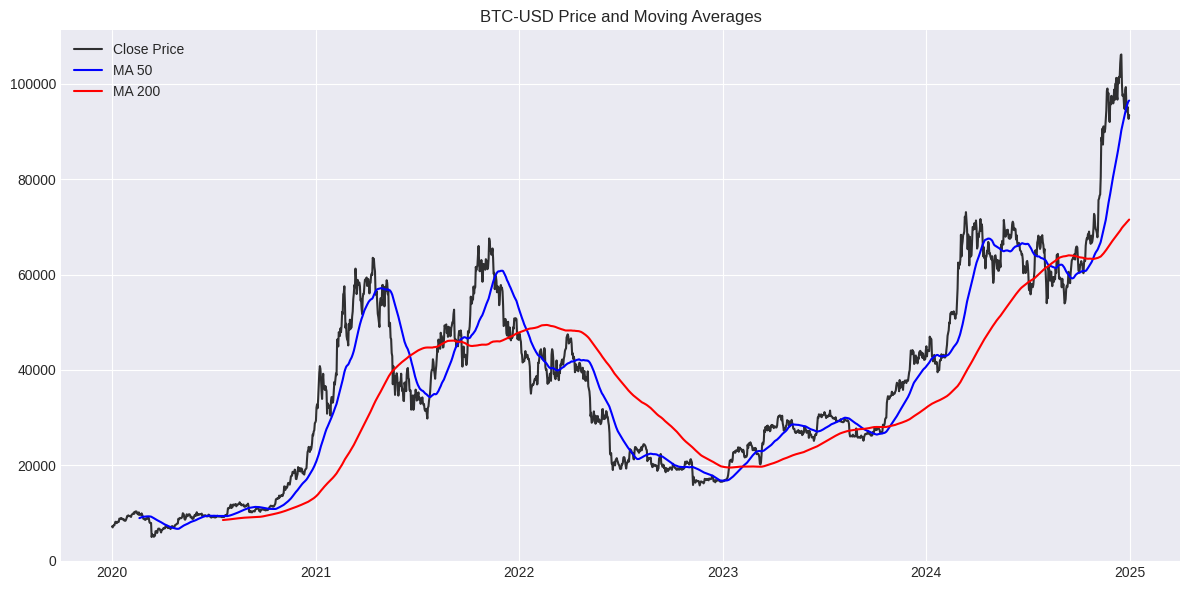

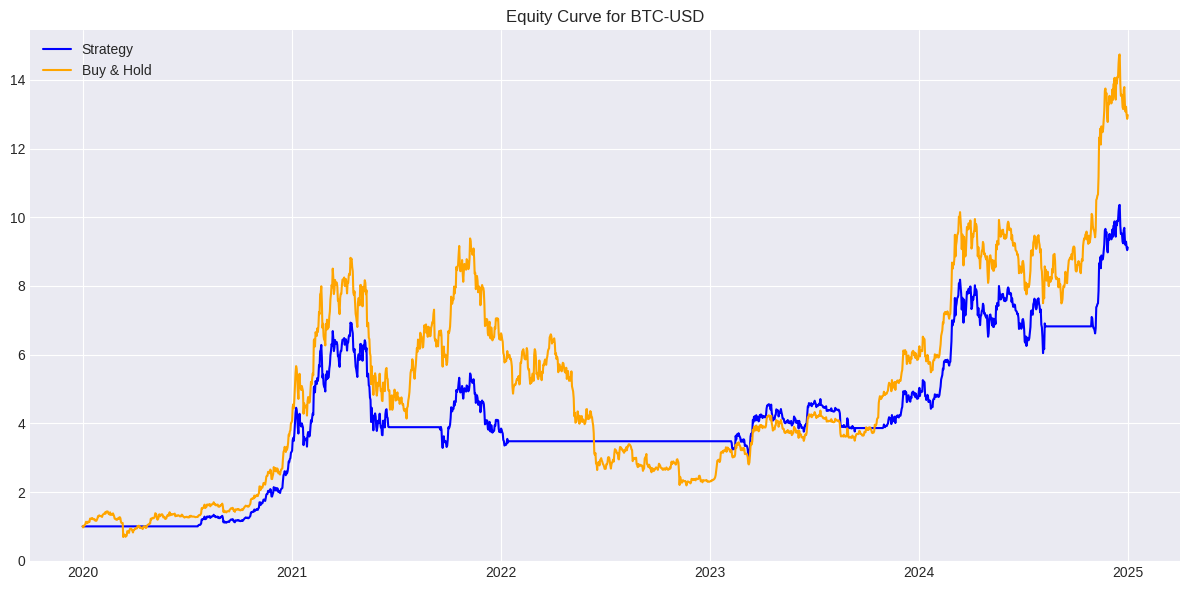

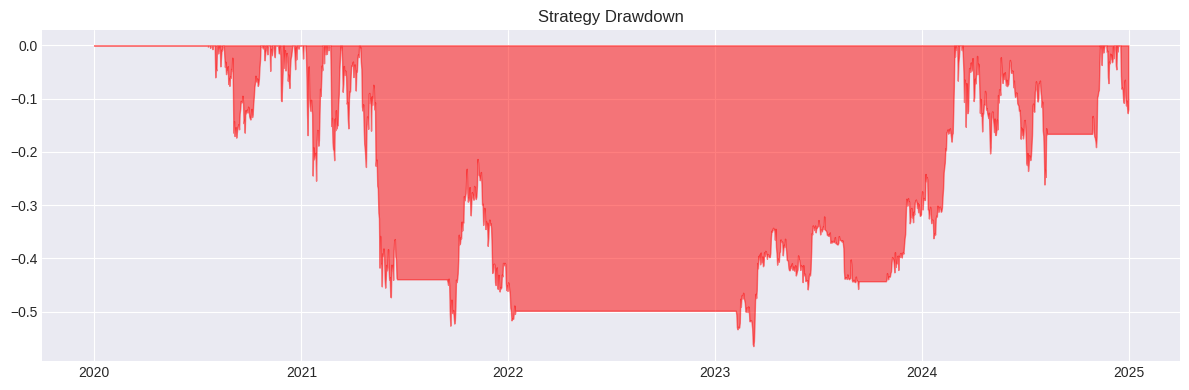

Results have been saved in the 'results/' directory.


In [11]:
if __name__ == "__main__":
    main()